# Notebook Examples for Chapter 6

## 6.2 Training data separability

In [1]:
import ee
#ee.Authenticate()
ee.Initialize()

In [2]:
# first 5 principal components of ASTER image
image = ee.Image('projects/ee-mortcanty/assets/CRC5/AST_20070501_pca') \
                                      .select(0,1,2,3,4)
# training data
table = ee.FeatureCollection('projects/ee-mortcanty/assets/CRC5/train')
trainData = image.sampleRegions(table,['CLASS_ID'])
print(trainData.size().getInfo()  )

7173


In [3]:
def jmsep(class1, class2, image, table):
    # Jeffries-Matusita separability    
    table1 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class1-1)))
    m1 = image.reduceRegion(ee.Reducer.mean(),table1)\
              .toArray() 
    s1 = image.toArray() \
         .reduceRegion(ee.Reducer.covariance(),table1)\
         .toArray()
    table2 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class2-1)))
    m2 = image.reduceRegion(ee.Reducer.mean(),table2)\
              .toArray()
    s2 = image.toArray() \
        .reduceRegion(ee.Reducer.covariance(),table2,15)\
              .toArray()
    m12 = m1.subtract(m2)  
    m12 = ee.Array([m12.toList()]) # makes 2D matrix  
    s12i = s1.add(s2).divide(2).matrixInverse()
    # first term in Bhattacharyya distance
    B1 = m12.matrixMultiply(
          s12i.matrixMultiply(m12.matrixTranspose())) \
            .divide(8)
    ds1 = s1.matrixDeterminant()
    ds2 = s2.matrixDeterminant() 
    ds12 = s1.add(s2).matrixDeterminant()
    # second term
    B2 = ds12.divide(2).divide(ds1.multiply(ds2).sqrt())\
             .log().divide(2)
    B = ee.Number(B1.add(B2).project([0]).toList().get(0))
    # J-M separability
    return ee.Number(1).subtract(ee.Number(1) \
             .divide(B.exp())).multiply(2)

In [4]:
print(jmsep(7,8,image,table).getInfo())

1.9026665318307807


In [5]:
def band_mean(current,prev):
    current = ee.String(current)
    prev = ee.Dictionary(prev)
    trainData = ee.FeatureCollection(prev.get('trainData'))
    class_id = prev.get('class_id')
    means = ee.List(prev.get('means'))
    mu = trainData.filter(ee.Filter.eq('CLASS_ID',class_id)).aggregate_mean(current)
    return ee.Dictionary({ 'trainData':trainData,'class_id':class_id,'means':means.add(mu) })

def class_mean(trainData,class_id,bandNames):
    first = ee.Dictionary({'trainData':trainData,'class_id':str(class_id),'means':ee.List([])})
    return ee.Dictionary(bandNames.iterate(band_mean,first)).get('means')

mu = ee.Array(class_mean(trainData,7,image.bandNames()))
print(mu.getInfo())

[-28.38586464084563, -13.477546924748925, 0.23433266364269972, -0.40716485753027765, -0.2885723078052682]


### 6.3 Maximum likelihood classification

#### 6.3.1 Naive Bayes on the GEE

In [5]:
import geemap
# rename the class ids from strings to integers
trainData = image.sampleRegions(table,['CLASS_ID']) \
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
# train a naive Bayes classifier    
classifier = ee.Classifier.smileNaiveBayes()
trained = classifier\
    .train(trainData,'CLASS_ID',image.bandNames())
# classify the image and display    
classified = image.classify(trained)
map = geemap.Map()
map.centerObject(classified, 12)
map.addLayer(classified.byte(), {'min': 0.0, 'max': 10.0, 'palette': 'jet' }, 'Naive Bayes')
map

Map(center=[50.884108588959045, 6.426768742530182], controls=(WidgetControl(options=['position', 'transparent_…

#### 6.3.2 Scripts for supervised classification

In [10]:
%run scripts/classify -p [1,2,3,4,5] -a 1 imagery/AST_20070501_pca.tif imagery/train.shp

Training with MaxLike
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.0013897418975830078
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.5309035778045654
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_MaxLike.tst
done


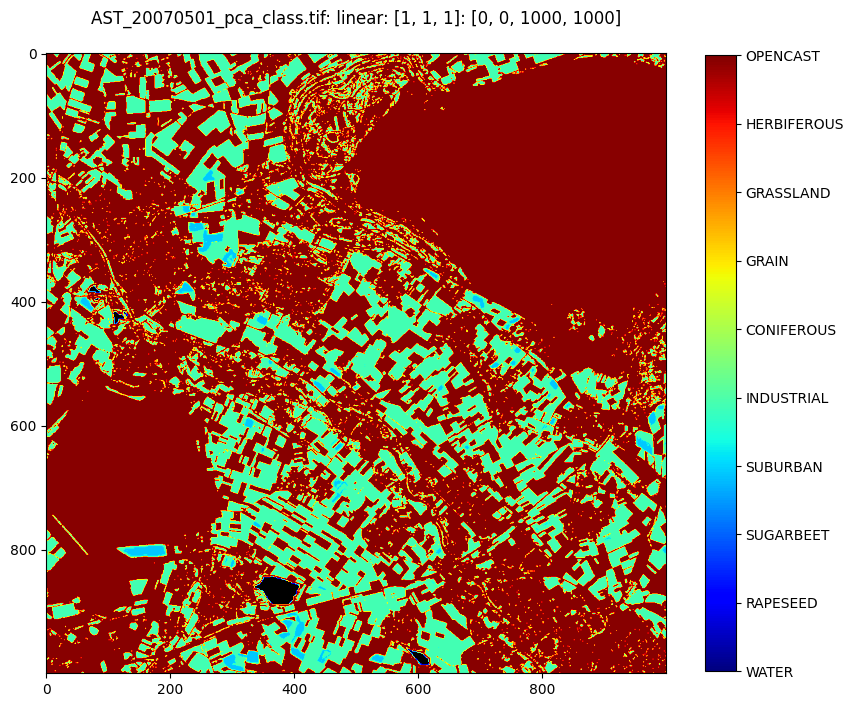

In [11]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" \
-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_5.eps'

### 6.4 Gaussian kernel

In [12]:
%run scripts/classify -p [1,2,3,4,5] -a 2 -P imagery/AST_20070501_pca.tif imagery/train.shp

Training with Gausskernel
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
sigma: 0.001000  error: 0.348062
sigma: 0.100000  error: 0.049604
sigma: 1.000000  error: 0.201125
sigma: 0.443769  error: 0.130471
sigma: 0.231308  error: 0.100459
sigma: 0.150155  error: 0.070654
sigma: 0.062185  error: 0.036474
sigma: 0.038815  error: 0.029596
sigma: 0.024371  error: 0.026469
sigma: 0.015444  error: 0.028345
sigma: 0.025663  error: 0.026469
sigma: 0.025017  error: 0.026469
sigma: 0.024770  error: 0.026261
sigma: 0.024618  error: 0.026469
sigma: 0.024817  error: 0.026261
sigma: 0.024842  error: 0.026261
sigma: 0.024909  error: 0.026261
sigma: 0.024950  error: 0.026261
sigma: 0.024976  error: 0.026469
elapsed time 23.70091700553894
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 358.4790234565735
class probabilities writt

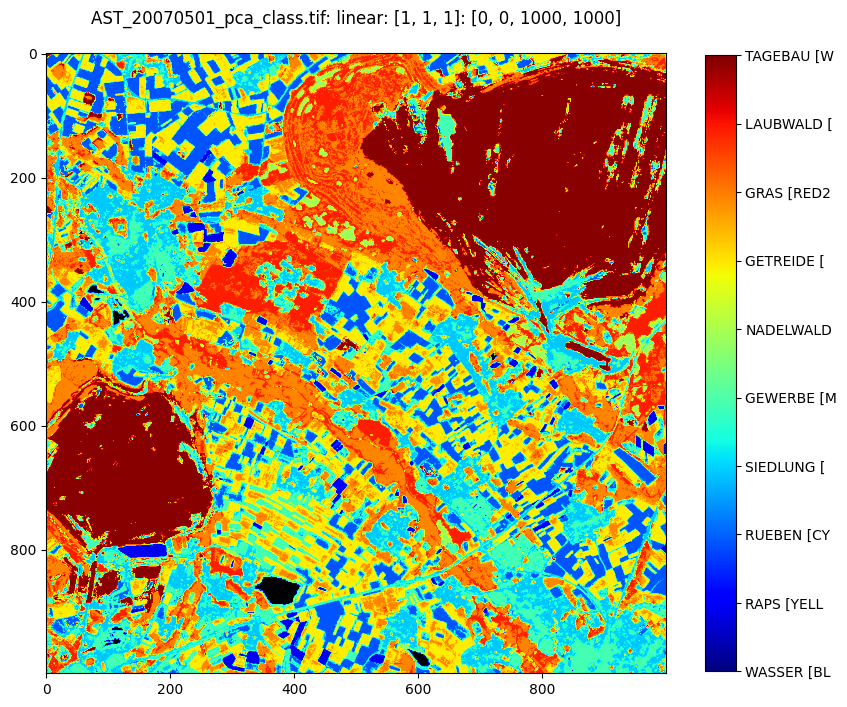

In [13]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r "['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']" \
-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_6.eps'

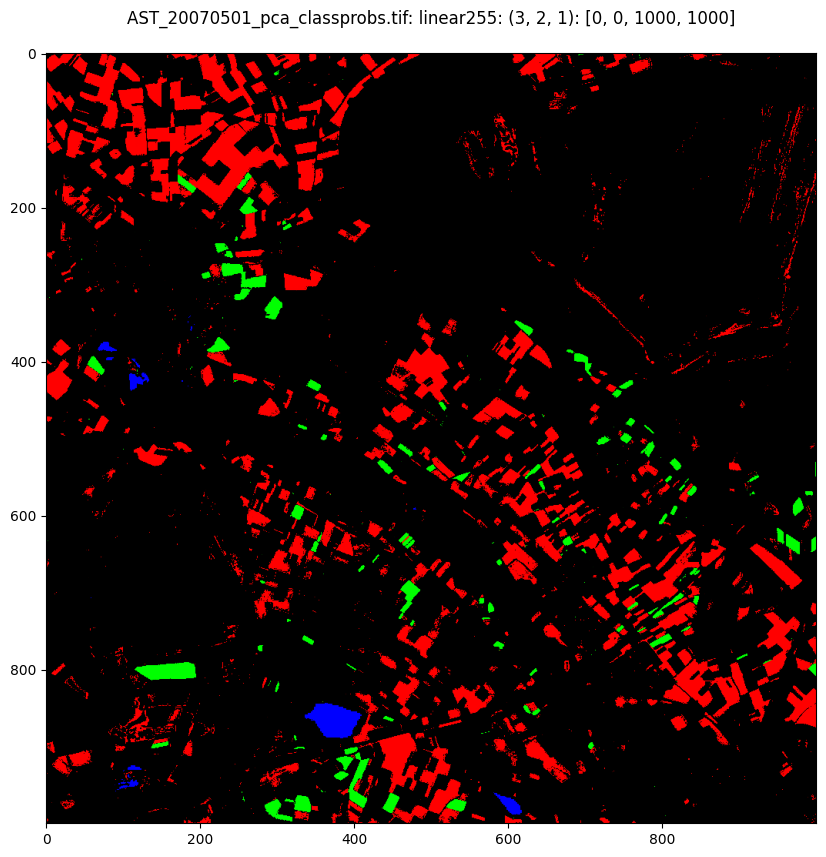

In [13]:
%run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -p [3,2,1] -e 1 \
-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_7.eps'

### 6.5 Neural networks
#### 6.5.3 Backpropagation

Training with NNet(Backprop)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 491.03439497947693
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.4718918800354004
thematic map written to: imagery/AST_20070501_pca_class.tif


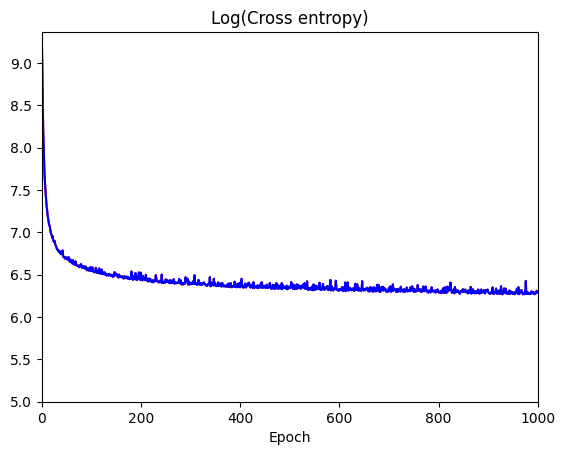

test results written to: imagery/AST_20070501_pca_NNet(Backprop).tst
done


In [9]:
%run scripts/classify -p [1,2,3,4,5] -a 3 -e 1000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with NNet(Congrad)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 5.3627989292144775
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.3409249782562256
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif


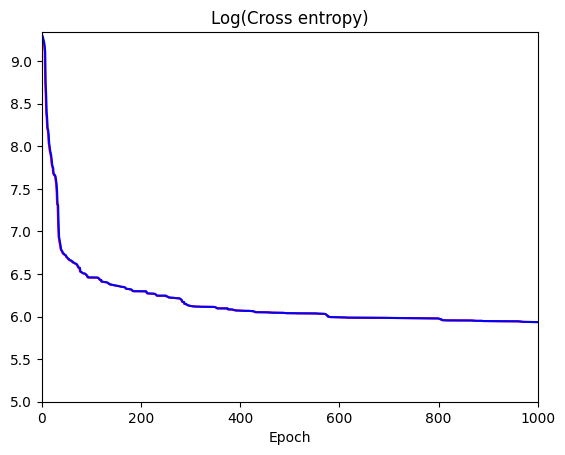

test results written to: imagery/AST_20070501_pca_NNet(Congrad).tst
done


In [14]:
%run scripts/classify -p [1,2,3,4,5] -P -a 4 -e 1000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with NNet(Kalman)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 32.64310693740845
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.3057684898376465
thematic map written to: imagery/AST_20070501_pca_class.tif


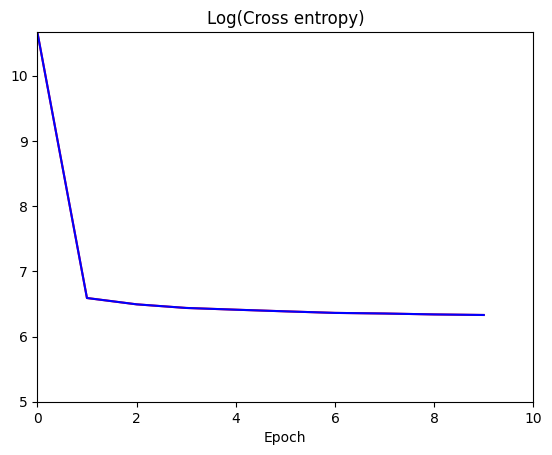

test results written to: imagery/AST_20070501_pca_NNet(Kalman).tst
done


In [15]:
run scripts/classify -p [1,2,3,4,5] -a 5 -e 10 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

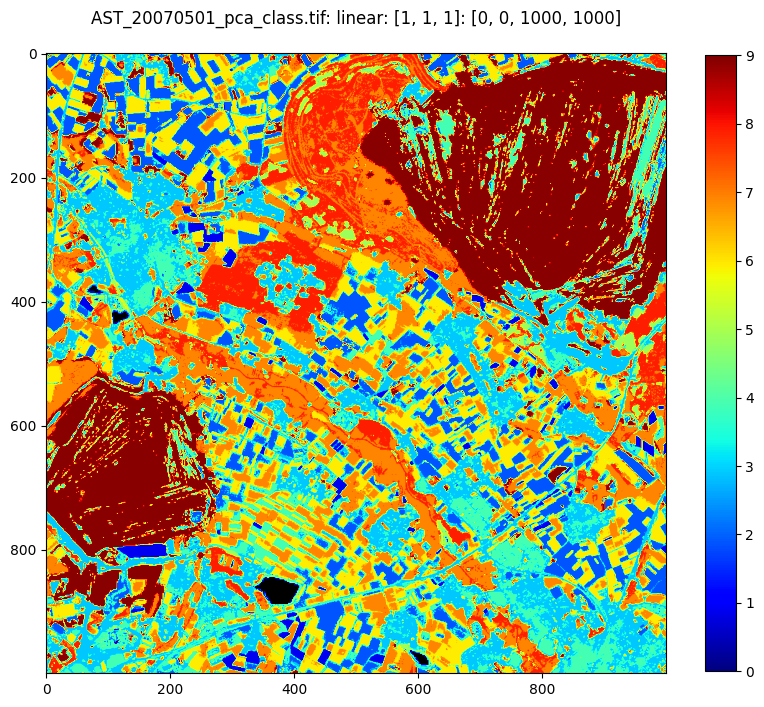

In [16]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif  -c

#### 6.5.4 Deep learning networks

In [17]:
run scripts/classify -p [1,2,3,4,5] -a 6 -e 1000 -L [10,10,10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 186.9596734046936
classifying...
row: 0
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step
row: 100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 590us/step
row: 200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step
row: 300
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step
row: 400
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 600us/step
row: 500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step
row: 600
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step
row: 700
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step
row: 800
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step
row: 900
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 596us/step
elapsed time 18.736236810684204
thematic map written to: imagery/AST_20070501_pca_class.tif
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
test results written to: imagery/AST_20070501_pca_Dnn(tensorflow).tst
done


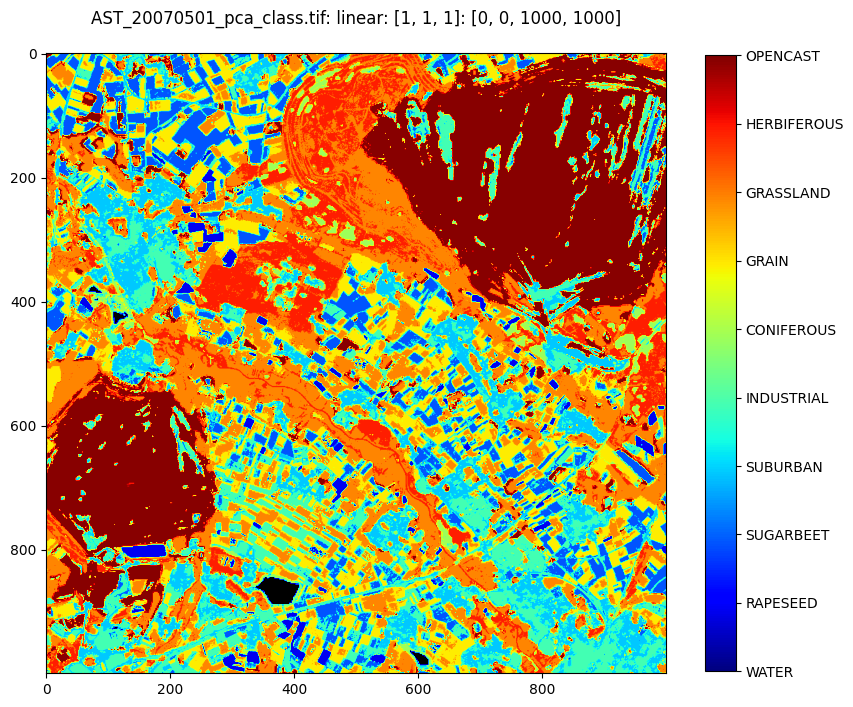

In [18]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']"

### Support Vector Machine

In [19]:
run scripts/classify -p [1,2,3,4,5] -a 7 -P imagery/AST_20070501_pca.tif imagery/train.shp

Training with SVM
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.2451941967010498
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 69.40814352035522
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_SVM.tst
done


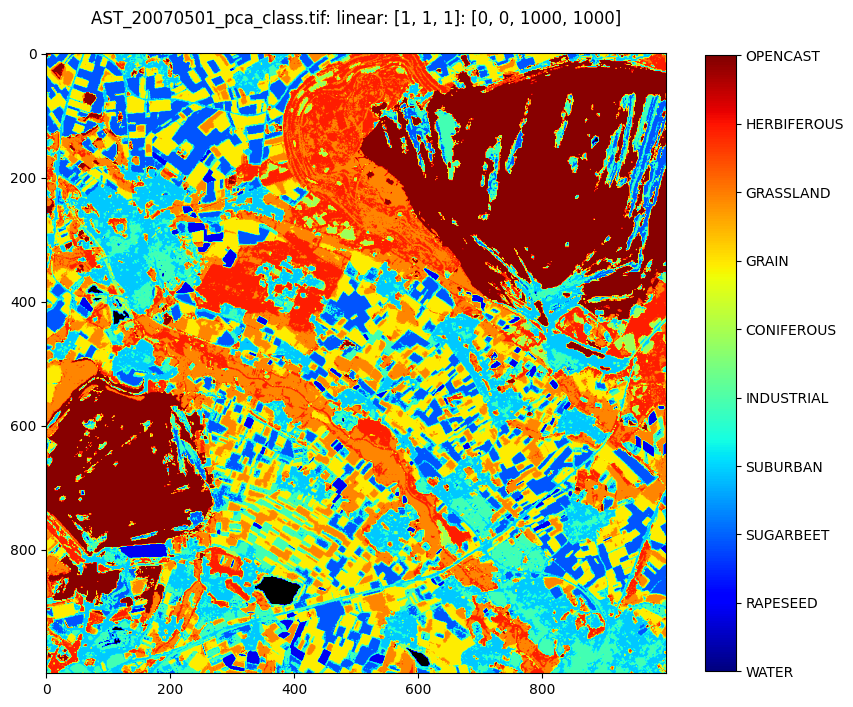

In [20]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c\
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" \
-s '/home/mort/LaTeX/new projects/CRC5/Chapter6/fig6_19.eps'

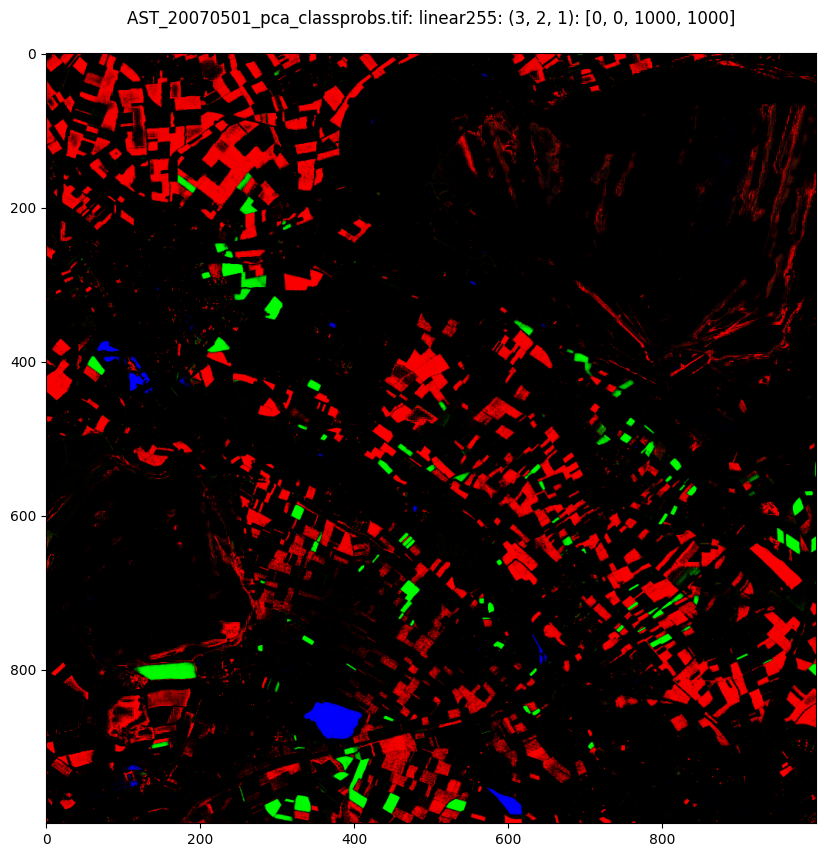

In [3]:
%run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -p [3,2,1] -e 1

In [11]:
# train a SVM classifier  
import geemap
classifier = ee.Classifier.libsvm(kernelType='RBF'
                                ,gamma=0.1,cost=10)
trainData = image.sampleRegions(table,['CLASS_ID']) \
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
trained = classifier.\
    train(trainData,'CLASS_ID',image.bandNames())
# classify the image and display    
classified = image.classify(trained)
map = geemap.Map()
map.centerObject(classified, 12)
map.addLayer(classified.byte(), {'min': 0.0, 'max': 10.0, 'palette': 'jet'}, 'SVM')
map

Map(center=[50.884108588959045, 6.426768742530182], controls=(WidgetControl(options=['position', 'transparent_…